In [11]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.stats import spearmanr

device = "cuda" if torch.cuda.is_available() else "cpu"

clipmodel, preprocess = clip.load("ViT-B/16", device=device)
clip_inres = clipmodel.visual.input_resolution
clip_ksize = clipmodel.visual.conv1.kernel_size

In [2]:
def attention_layer(q, k, v, num_heads=1):
    "Compute 'Scaled Dot Product Attention'"
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    q = q * scaling
    
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    attn_output_heads = torch.bmm(attn_output_weights, v)
    assert list(attn_output_heads.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output_heads.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights
    

def clip_encode_dense(x,n):
    vision_width = clipmodel.visual.transformer.width
    vision_heads = vision_width // 64
    print("[vision_width and vision_heads]:", vision_width, vision_heads)
    
    # modified from CLIP
    #x = x.half() removing to adapt to a cpu only system
    x = clipmodel.visual.conv1(x)  
    feah, feaw = x.shape[-2:]

    x = x.reshape(x.shape[0], x.shape[1], -1) 
    x = x.permute(0, 2, 1) 
    class_embedding = clipmodel.visual.class_embedding.to(x.dtype)
    x = torch.cat([class_embedding + torch.zeros(x.shape[0], 1, x.shape[-1]).to(x), x], dim=1)

    ## scale position embedding as the image w-h ratio
    pos_embedding = clipmodel.visual.positional_embedding.to(x.dtype)
    tok_pos, img_pos = pos_embedding[:1, :], pos_embedding[1:, :]
    pos_h = clip_inres // clip_ksize[0]
    pos_w = clip_inres // clip_ksize[1]
    assert img_pos.size(0) == (pos_h * pos_w), f"the size of pos_embedding ({img_pos.size(0)}) does not match resolution shape pos_h ({pos_h}) * pos_w ({pos_w})"
    img_pos = img_pos.reshape(1, pos_h, pos_w, img_pos.shape[1]).permute(0, 3, 1, 2)
    print("[POS shape]:", img_pos.shape, (feah, feaw))
    img_pos = torch.nn.functional.interpolate(img_pos, size=(feah, feaw), mode='bicubic', align_corners=False)
    img_pos = img_pos.reshape(1, img_pos.shape[1], -1).permute(0, 2, 1)
    pos_embedding = torch.cat((tok_pos[None, ...], img_pos), dim=1)
    x = x + pos_embedding
    x = clipmodel.visual.ln_pre(x)
    
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = torch.nn.Sequential(*clipmodel.visual.transformer.resblocks[:-n])(x)

    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []
    for TR in clipmodel.visual.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear    
        q, k, v = linear(x, TR.attn.in_proj_weight, TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(q, k, v, 1)  # vision_heads=1
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)
        
        x_after_attn = linear(attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)       
        x = x_after_attn + x_in
        x = x + TR.mlp(TR.ln_2(x))

    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clipmodel.visual.ln_post(x)
    x = x @ clipmodel.visual.proj
    return x, x_in, vs, qs, ks, attns, atten_outs, (feah, feaw)

In [3]:
_transform = Compose([
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def imgprocess(img, patch_size=[16, 16], scale_factor=1):
    w, h = img.size
    ph, pw = patch_size
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)


In [8]:
def prepare_img_text(img, texts) :
    # preprocess image and text
    img_preprocessed = preprocess(img).unsqueeze(0)
    text_processed = clip.tokenize(texts).cpu()
    # extract text featrue
    text_embedding = clipmodel.encode_text(text_processed)
    text_embedding = F.normalize(text_embedding, dim=-1)
    #print("[text embedding]:", text_embedding.shape)

    # extract image feature
    ori_img_embedding = clipmodel.encode_image(img_preprocessed)
    ori_img_embedding = F.normalize(ori_img_embedding, dim=-1)
    #print("[image embedding]:", ori_img_embedding.shape)

    # calculate the cosine similarity
    cosine = (ori_img_embedding @ text_embedding.T)
    #print("[cosine]:", cosine)
    
    img_processed = imgprocess(img).unsqueeze(0)
    #
    # x, vs, qs, ks, attns, atten_outs, (feah, feaw)
    outputs, last_feat, vs, qs, ks, attns, atten_outs, map_size = clip_encode_dense(img_processed, n=1)
    img_embedding = F.normalize(outputs[:,0], dim=-1)
    #print("[image embedding]:", img_embedding.shape)
    cosine = (img_embedding @ text_embedding.T)[0]
    #print("cosine:", cosine)

    # similarity between text prompt and patch features
    p_final = F.normalize(outputs[:,1:], dim=-1)
    cosine_p = (p_final @ text_embedding.T)[0].transpose(1,0).reshape(-1, *map_size)
    #print("[position similarity (cosine p)]:", cosine_p.shape)

    return cosine, qs, ks, vs, atten_outs, map_size

In [5]:
# generate ODAM map

def sim_qk(q, k):
    q_cls = F.normalize(q[:1,0,:], dim=-1) 
    k_patch = F.normalize(k[1:,0,:], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1) 
    cosine_qk_max = cosine_qk.max(dim=-1, keepdim=True)[0]
    cosine_qk_min = cosine_qk.min(dim=-1, keepdim=True)[0]
    cosine_qk = (cosine_qk-cosine_qk_min) / (cosine_qk_max-cosine_qk_min)
    return cosine_qk

def grad_eclip(c, qs, ks, vs, attn_outputs, map_size):
    ## gradient on last attention output
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]

        grad_cls = grad[:1,0,:]
        v_patch = v[1:,0,:]
        cosine_qk = sim_qk(q, k).reshape(-1)
        tmp_maps.append((grad_cls * v_patch * cosine_qk[:,None]).sum(-1)) 

    emap = F.relu_(torch.stack(tmp_maps, dim=0)).sum(0)
    return emap.reshape(*map_size)

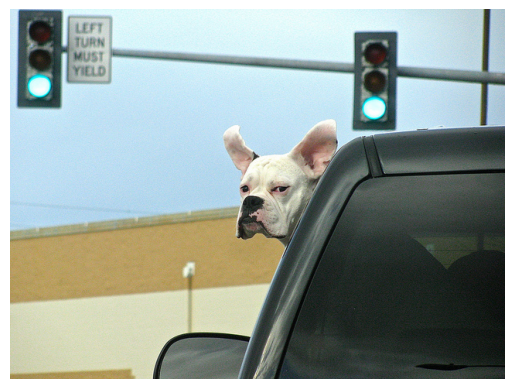

In [6]:
img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
img_gauss = img.filter(ImageFilter.GaussianBlur(radius=2))
images = [img, img_gauss]

text = ["a dog in a car waiting for traffic lights"] 


plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
results = []
for img in images:
     cosine, qs, ks, vs, atten_outs, map_size = (prepare_img_text(img, text))
     for c in cosine:
          results.append(grad_eclip(c, qs, ks, vs, atten_outs, map_size))

[vision_width and vision_heads]: 768 12
[POS shape]: torch.Size([1, 768, 14, 14]) (30, 40)
[vision_width and vision_heads]: 768 12
[POS shape]: torch.Size([1, 768, 14, 14]) (30, 40)
[tensor([[0.0115, 0.0160, 0.0210,  ..., 0.0000, 0.0106, 0.0082],
        [0.0147, 0.0357, 0.0256,  ..., 0.0000, 0.0137, 0.0018],
        [0.0193, 0.0419, 0.0443,  ..., 0.0000, 0.0140, 0.0019],
        ...,
        [0.0000, 0.0010, 0.0000,  ..., 0.0061, 0.0259, 0.0283],
        [0.0021, 0.0022, 0.0000,  ..., 0.0301, 0.0254, 0.0333],
        [0.0000, 0.0018, 0.0018,  ..., 0.0332, 0.0326, 0.0325]],
       grad_fn=<ViewBackward0>), tensor([[0.0139, 0.0000, 0.0286,  ..., 0.0000, 0.0068, 0.0000],
        [0.0067, 0.0302, 0.0574,  ..., 0.0000, 0.0049, 0.0000],
        [0.0407, 0.0391, 0.0515,  ..., 0.0000, 0.0055, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0222, 0.0216, 0.0256],
        [0.0000, 0.0000, 0.0000,  ..., 0.0340, 0.0305, 0.0399],
        [0.0000, 0.0000, 0.0000,  ..., 0.0503, 0.0418

In [24]:
import numpy as np
import cv2
import torch

def visualize_heatmap_overlay(hmap, raw_image, resize, alpha=0.5):
    image = np.asarray(raw_image.copy())

    if isinstance(hmap, torch.Tensor):
        hmap = hmap.unsqueeze(0) if hmap.dim() == 2 else hmap
        hmap = resize(hmap)[0].detach().numpy()
    else:
        hmap = resize(hmap[np.newaxis, ...])[0]

    hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min() + 1e-8)

    heatmap_color = cv2.applyColorMap((hmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = np.clip(image * (1 - alpha) + heatmap_color * alpha, 0, 255).astype(np.uint8)

    return overlay

### Spearman’s rank order correlation

In [16]:
from scipy.stats import spearmanr

map_original = results[0].detach().cpu().numpy()
map_perturb = results[1].detach().cpu().numpy()

flat_orig = map_original.flatten()
flat_perturb = map_perturb.flatten()

corr, p_val = spearmanr(flat_orig, flat_perturb)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_val:.3e}")

Spearman correlation: 0.801, p-value: 6.937e-269


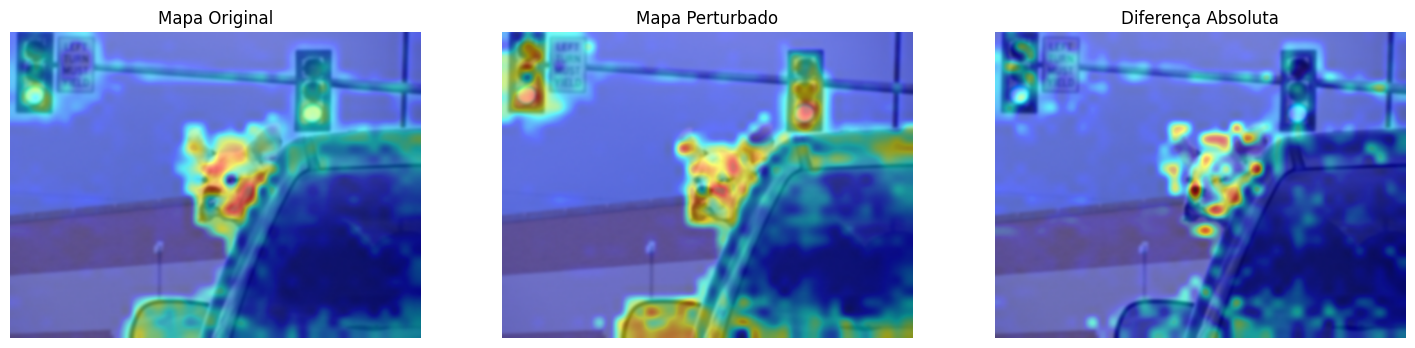

In [29]:
from torchvision.transforms import Resize, InterpolationMode

w, h = img.size

resize = Resize((h, w), interpolation=InterpolationMode.BICUBIC)  # ordem (altura, largura)

overlay_original = visualize_heatmap_overlay(results[0], img, resize)
overlay_perturb = visualize_heatmap_overlay(results[1], img_gauss, resize)

diff = abs(results[0].detach().cpu().numpy() - results[1].detach().cpu().numpy())
diff_overlay = visualize_heatmap_overlay(torch.tensor(diff), img, resize)
import matplotlib.pyplot as plt


plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Mapa Original")
plt.imshow(overlay_original)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Mapa Perturbado")
plt.imshow(overlay_perturb)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Diferença Absoluta")
plt.imshow(diff_overlay)
plt.axis('off')

plt.show()